In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping
from extraction.extract import generateNNdata

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


In [2]:
def genXy(data, lb, la, scaler):
    n_features = data.shape[1] - 2
    df = data.reindex()

    X = np.empty((0, lb, n_features))
    y = np.empty((0, la, 2))

    X_time = np.array([], dtype="datetime64")
    y_time = np.array([], dtype="datetime64")

    for i, row in df.iterrows():
        dfx = df.iloc[i : i + lb]
        x_vals = dfx.drop(columns=["timeslot", "date"]).values

        dfy = df.iloc[i + lb : i + lb + la]
        y_vals = dfy[["arrivalsArrivalDelay", "departuresDepartureDelay"]].values

        if dfx.shape[0] < lb or dfy.shape[0] < la:
            continue

        if dfx.date.nunique() > 1 or dfy.date.nunique() > 1:
            continue

        if dfx.date.unique()[0] != dfy.date.unique()[0]:
            continue

        x_vals = scaler.transform(x_vals)
        X = np.vstack((X, x_vals[None]))
        y = np.vstack((y, y_vals[None]))

        X_time = np.append(X_time, dfx.timeslot.iloc[0])
        y_time = np.append(y_time, dfy.timeslot.iloc[0])

    return X, y, X_time, y_time


In [3]:
timeinterval = 30
airport = "EGLL"
lookback, lookahead = 6, 6


In [4]:
dataset = (
    generateNNdata(
        airport,
        timeslotLength=timeinterval,
        catagoricalFlightDuration=False,
        forceRegenerateData=True,
    )
    .drop(columns=["departuresArrivalDelay", "arrivalsDepartureDelay"])
    .assign(hour=lambda d: d.timeslot.dt.hour)
    .assign(capacityFilled=lambda d: d.capacityFilled * 100)
)


Generating NN data for EGLL with a timeslot length of 30 minutes


In [5]:
# randomly split train, validation, test with 60%, 20%, 20%

np.random.seed(42)
dates = dataset.date.unique()
np.random.shuffle(dates)

idx_split = int(len(dates) * 0.75)

train_dates = dates[:idx_split]
test_dates = dates[idx_split:]

train_data = dataset.query("date in @train_dates").sort_values('timeslot')
test_data = dataset.query("date in @test_dates").sort_values('timeslot')


In [6]:
scaler = StandardScaler()
scaler.fit(dataset.drop(columns=["timeslot", "date"]).values)

StandardScaler()

In [7]:
X_train, y_train, X_train_time, y_train_time = genXy(train_data, lookback, lookahead, scaler)
X_test, y_test, X_test_time, y_test_time = genXy(test_data, lookback, lookahead, scaler)

y_train_arr, y_train_dep = y_train[:, :, 0], y_train[:, :, 1]
y_test_arr, y_test_dep = y_test[:, :, 0], y_test[:, :, 1]


2022-02-08 17:27:41.513368: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 17:27:41.940355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1245 MB memory:  -> device: 0, name: Quadro K620, pci bus id: 0000:03:00.0, compute capability: 5.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 400)            660800    
                                                                 
 dropout (Dropout)           (None, 6, 400)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 200)            480800    
                                                                 
 dropout_1 (Dropout)         (None, 6, 200)            0         
                                                                 
 time_distributed (TimeDistr  (None, 6, 100)           20100     
 ibuted)                                                         
                                                                 
 dropout_2 (Dropout)         (None, 6, 100)            0         
                                                        

2022-02-08 17:27:45.077804: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605


238/238 [==============================] - 7s 16ms/step - loss: 72.9996 - val_loss: 49.5745
Epoch 2/100
238/238 [==============================] - 3s 13ms/step - loss: 49.4300 - val_loss: 49.9205
Epoch 3/100
238/238 [==============================] - 3s 13ms/step - loss: 46.5480 - val_loss: 45.1616
Epoch 4/100
238/238 [==============================] - 3s 13ms/step - loss: 45.0986 - val_loss: 43.7330
Epoch 5/100
238/238 [==============================] - 3s 13ms/step - loss: 43.8779 - val_loss: 40.5960
Epoch 6/100
238/238 [==============================] - 3s 13ms/step - loss: 42.8256 - val_loss: 39.4579
Epoch 7/100
238/238 [==============================] - 3s 14ms/step - loss: 42.3727 - val_loss: 38.3225
Epoch 8/100
238/238 [==============================] - 3s 13ms/step - loss: 41.8072 - val_loss: 37.8946
Epoch 9/100
238/238 [==============================] - 3s 13ms/step - loss: 41.4904 - val_loss: 37.5331
Epoch 10/100
238/238 [==============================] - 3s 13ms/step - loss:

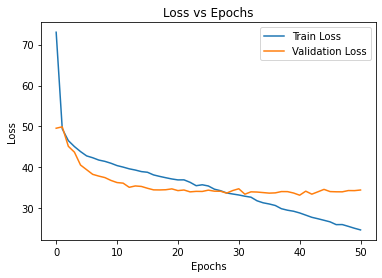

In [8]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(400, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(200, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(100)))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(2)))

model.compile(loss="mse", optimizer="adam")

model.summary()

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Fit data
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    # verbose=0,
    shuffle=False,
    callbacks=[es],
)

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [15]:
y_test_hat = model.predict(X_test)


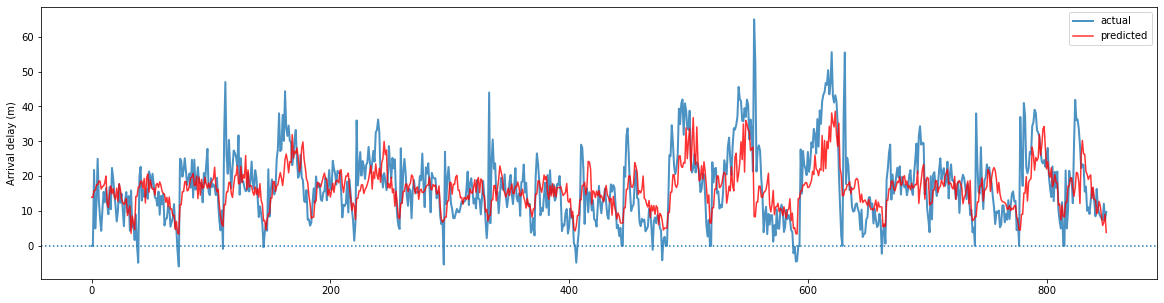

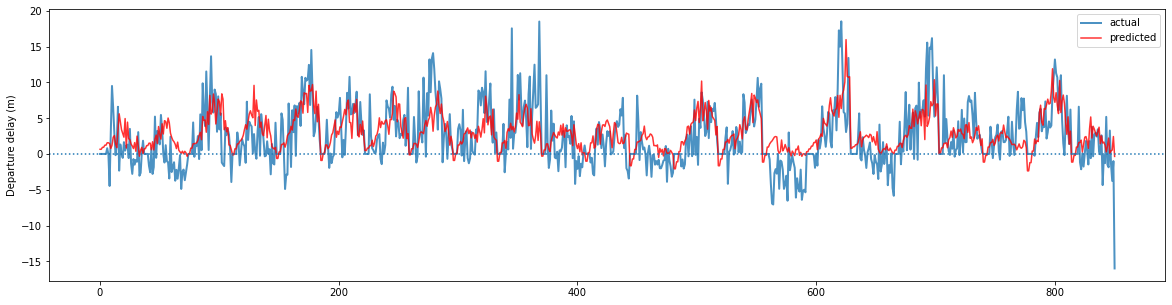

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(y_test_arr[:, 0], lw=2, alpha=0.8, label="actual")
plt.plot(y_test_hat[:, 0, 0], color="r", alpha=0.8, label="predicted")
plt.axhline(0, ls=":")
plt.ylabel("Arrival delay (m)")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(y_test_dep[:, 0], lw=2, alpha=0.8, label="actual")
plt.plot(y_test_hat[:, 0, 1], color="r", alpha=0.8, label="predicted")
plt.axhline(0, ls=":")
plt.ylabel("Departure delay (m)")
plt.legend()
plt.show()


In [16]:
results = pd.concat(
    [
        pd.DataFrame().assign(time=y_test_time),
        pd.DataFrame(
            y_test[:, :, 0].round().astype(int),
            columns=[f"arr_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test[:, :, 1].round().astype(int),
            columns=[f"dep_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 0].round().astype(int),
            columns=[f"arr_est_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 1].round().astype(int),
            columns=[f"dep_est_{n}m" for n in range(30, 181, 30)],
        ),
    ],
    axis=1,
)

# results


In [17]:
res = dict()
for i in range(1, 7):
    res[i] = {
        "arr_mae": mean_absolute_error(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "arr_rmse": mean_squared_error(
            results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"], squared=False
        ),
        "arr_r2": r2_score(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "dep_mae": mean_absolute_error(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
        "dep_rmse": mean_squared_error(
            results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"], squared=False
        ),
        "dep_r2": r2_score(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
    }

pd.DataFrame.from_dict(res, orient="index")

,arr_mae,arr_rmse,arr_r2,dep_mae,dep_rmse,dep_r2
1,6.102233,8.278850,0.347365,2.595770,3.468678,0.285668
2,5.665100,7.517547,0.447342,2.576968,3.433950,0.318699
3,5.312573,7.176391,0.497310,2.761457,3.727813,0.266089
4,5.282021,7.182120,0.523072,2.883666,3.847260,0.254639
5,5.212691,7.203440,0.542294,2.951821,3.997061,0.228459
6,5.175088,7.189070,0.557908,2.869565,3.952717,0.251061


In [ ]:

results.to_csv("data/airport_delay_lstm_results.csv", index=False)
